# Case Study 12 - R Branching Simulation 
## Team - Murali Parthasarathy, Sanjay Jagalarmudi, Amit Patel

## Objective
Branching process is used here to study the distribution of completion times of parallel program/jobs including the parent and sub jobs. We are going to review the branching process from chapter 7 from Text book "DataScience in R" by Nolan and Lang. And further analyse the Question 10 at the end of the chapter. 

Branching process defines the process in which initial job generates other jobs at random times with known distribution. And the sub jobs wait until the parent completes before they start running. Sub jobs can spawn jobs of their own as soon as they are generated. The goal is to understand how the job creation rate and job completion rates effect the total completion time of the system. 

Monte Carlo is a simple simulation method. Where we can generate random variable from a distribution that meets the criteria of parameters we are studying. We will focus on different Job creation Rate(Lambda) and Job complete rate (Kappa)and how they effection the completion times of the system. By running the simulation many times we try to understand the distribution. 



### Monte Carlo Simulation
We start the simulation with seed so we can replicate the study. Using different value from the textbook to understand the process better. We are using lambda=0.5 and Kappa=0.3 same as in textbook.

In [78]:
seedx = 20170815
set.seed(seedx)

In [52]:
#Job Creation rate
lambda = 0.5
births = replicate(1000,rexp(1,rate = lambda))
mean(births)

[1] 2.075549

In [59]:
#Job Completion rate
kappa = 0.3
deaths = replicate(1000,rexp(1,rate = kappa))
mean(deaths)

[1] 3.333211

### Generate Kids function
Simulation function from textbook. Creating modular functions in R makes the code readable and reusable. The following function generates the subjobs for the given parent's BirthTime and Completion time. 

In [72]:
genBirth = function(currentTime, cTime, births = numeric(), lambda = 0.5) {
                # Generate birth time of next job after currentTime
                mostRecent = rexp(1, rate = lambda) + currentTime
    
                if (mostRecent > cTime) 
                  return(births)
                else {
                  births = c(births, mostRecent)
                  genBirth(currentTime = mostRecent, cTime, births, lambda)
                }
              }
    
genKidsR = function(bTime, cTime, lambda = 0.5, kappa = 0.3) {
                # Parent job born at bTime and completes at cTime
                kidBirths = genBirth(bTime, cTime, lambda = lambda)

                # generate lifetimes for all offspring
                numKids = length(kidBirths)
                runtime = rexp(numKids, rate = kappa)
                kidDeaths = rep(cTime, numKids) + runtime

                data.frame(births = kidBirths, completes = kidDeaths)
             } 


In [73]:
set.seed(seedx)

In [79]:
numKids = replicate(1000, nrow(genKidsR(1, 6)))
mean(numKids)

[1] 2.497

In [80]:
# Sample standard error 
sqrt(2.5/1000)

[1] 0.05

### Testing Results
### Average Test
The average number of kids expected is 0.5(6-1) = 2.5
We see that our sample average of 2.497 is with in 1 SE as expected. 
### Poisson distribution Test
Comparing the distribution of the numKids with poisson distribution. From the plot below we can see that they are very close. 

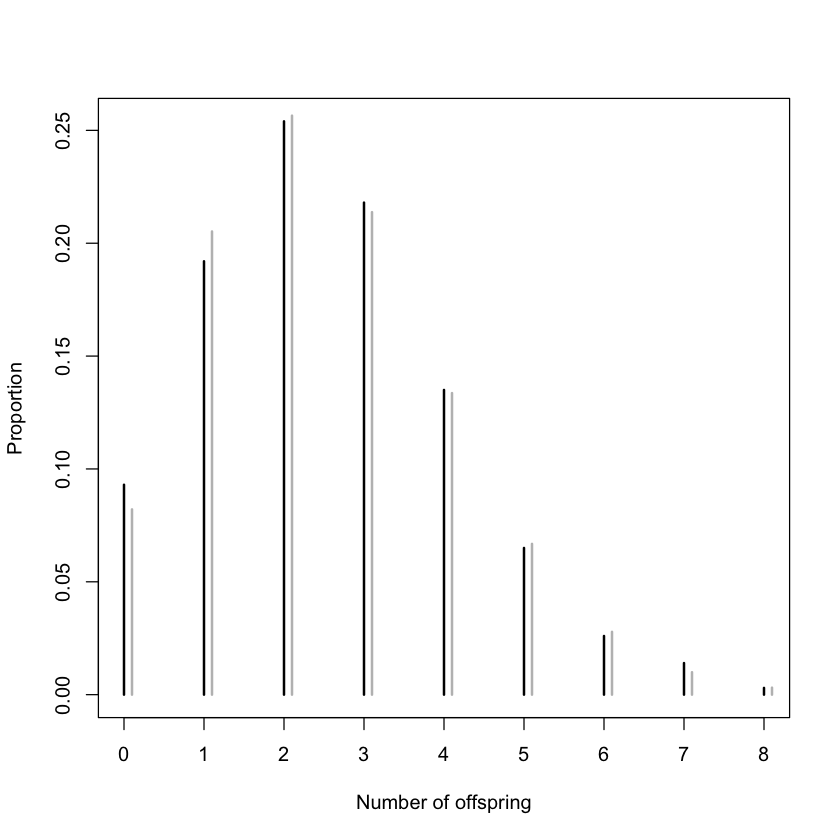

In [85]:
eprobs = table(numKids)/length(numKids)
probs = dpois(x = 0:max(numKids), lambda = 2.5)

plot(eprobs, type = "h",
     ylab = "Proportion", xlab = "Number of offspring")
segments(x0 = 0.1 + 0:max(numKids), y0 = rep(0, max(numKids)), 
         y1 = probs, col="grey", lwd = 2)

### Complete Simulation
FamilyTree function from text book which is the complete simulation function to genrate the full job tree of the system. Following is most performent version from the text book. It also limits the branching process by generations and max offspring count.

In [96]:
genKidsV = function(bTimes, cTimes, parentID, lambda = 0.5, kappa = 0.3) {
       # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), lambda = lambda * parentAge)
  
  if (sum(numKids) == 0) return(NULL)
  
       # Determine the birth times of the children  
  kidStats = 
    mapply(function(n, min, max) {
      births = sort(runif(n, min, max))
      runtimes = rexp(n, rate = kappa)
      completes = rep(max, n) + runtimes
      data.frame(births, completes)
    },
           n = numKids , min = bTimes, max = cTimes, 
           SIMPLIFY = FALSE)
  
 
  return(data.frame(parentID = rep(parentID, numKids),
                    kidID = 1:sum(numKids), 
                    births = unlist(lapply(kidStats, "[[", "births")), 
                    completes = unlist(lapply(kidStats,"[[", "completes"))
                    ))
}

familyTree = function(lambda = 0.5, kappa = 0.3, 
                      maxGen = 10, maxOffspring = 1000) {

       # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
       # Generate root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = rexp(1, rate = kappa))
  
  currentNumOffspring = 0

       # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, kappa = kappa)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ]) 
    allGens[[ i ]] = nextGen
    currentNumOffspring = currentNumOffspring + nrow(nextGen)
    if (currentNumOffspring > maxOffspring) 
      return(allGens[1:i])
  }  
  allGens
}


In [97]:
exptOne = function(l, k, mG, mO){
       # Helper function to call familyTree
       # Returns - summary statistics for analysis,
  
  aTree = familyTree(lambda = l, kappa = k, maxGen = mG,
                      maxOffspring = mO)
  numGen = length(aTree)
  numJobs = sum(sapply(aTree, nrow))
  c(numGen, numJobs)
}

In [101]:
seed2 = 2017123100
set.seed(seed2)
exptOne(1, 0.5, 100, 1000)

[1]    6 1497

### Replicating the Simulation 
Monte Carlo Branching Process Analysis. To study the parameters of the branching process we run the simulation multiple times using following MCBA function. 

In [102]:
MCBA = function(params, repeats = 5, mG = 10, mO = 1000){
       # params: matrix columns of lambda and kappa values
       # For each lambda and kappa pair, run "repeats" times
  
  n = nrow(params)
  mcResults = vector("list", length = n)
  
  for (i in 1:n) {
    cat("param set is ", i, "\n")
    mcResults[[i]] = replicate(repeats,
                               exptOne(l = params[i, 1],
                                       k = params[i, 2],
                                       mG = mG, mO = mO))
  }
  mcResults
}

In [106]:
lambdas = c(seq(0.1, 0.6, by = 0.1), seq(0.8, 2, by = 0.2), 
            seq(2.25, 3, by = 0.25))
kappas = c(lambdas, 3.25, 3.50, 3.75, 4.00, 4.50, 5.00)

paramGrid = as.matrix(expand.grid(lambdas, kappas))

In [110]:
mcGrid = MCBA(params = paramGrid, repeats = 200, mG = 20,
                mO = 1000)

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set is  27 
param set is  28 
param set is  29 
param set is  30 
param set is  31 
param set is  32 
param set is  33 
param set is  34 
param set is  35 
param set is  36 
param set is  37 
param set is  38 
param set is  39 
param set is  40 
param set is  41 
param set is  42 
param set is  43 
param set is  44 
param set is  45 
param set is  46 
param set is  47 
param set is  48 
param set is  49 
param set is  50 
param set is  51 
param set is  52 
param set is  53 
param set is  54 
param set is  55 
param set is  56 
p

In [111]:
logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))


In [112]:
UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )
color3 = c("#b3cde3aa", "#8856a7aa", "#810f7caa")
colors = color3[UQCut]

null device 
          1

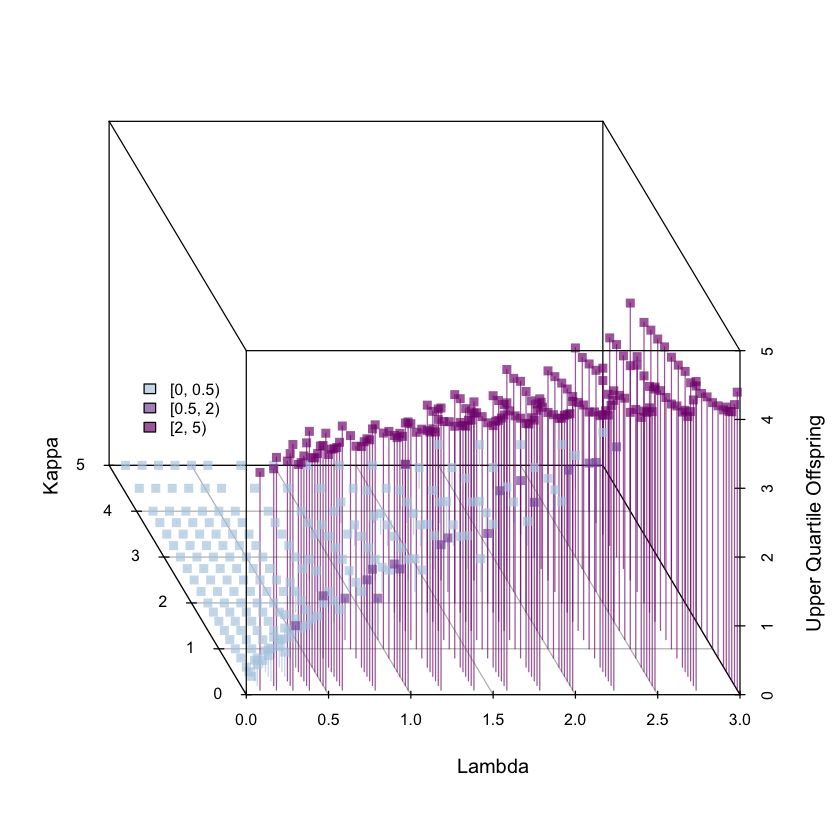

In [113]:
library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                    z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Kappa",
                    zlab = "Upper Quartile Offspring",
                    angle = 120, type="h")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 5)"), 
       fill = color3)

dev.off()

null device 
          1

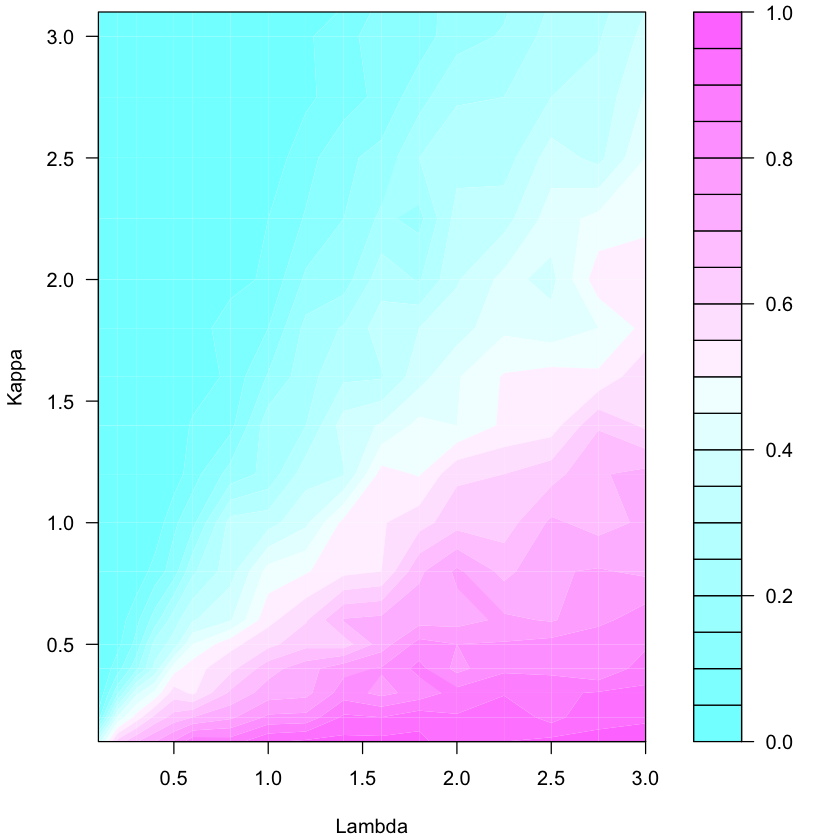

In [114]:
oldPar  = par(mar = c(4.1, 4.1, 0.5, 0.5))

mcGridAlive = sapply(mcGrid, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

filled.contour(lambdas, kappas, 
               matrix(mcGridAlive, nrow = length(lambdas), 
                      ncol = length(kappas)), 
               xlab = "Lambda", ylab = "Kappa", 
               xlim = c(0.1, 3), ylim = c(0.1, 3.1)) 

par(oldPar)
dev.off()


### Question 10 from the book 
We are going to run the simulation by fixing kappa at 1 and changing the values of lambdas. And run the simulation again with same set of lambdas but with different kappa(not equal to 1). We want to review if the results are similar in both simulations where the ratio of lambda and kappa are same.  

In [122]:
lambdas = c(seq(0.1, 3, by = 0.1))

paramGrid = as.matrix(expand.grid(lambdas))
paramGrid2 = as.matrix(expand.grid(lambdas))

paramGrid = cbind(paramGrid,1)
paramGrid2 = cbind(paramGrid2,2)

paramGrid
paramGrid2

Var1,
0.1,1
0.2,1
0.3,1
0.4,1
0.5,1
0.6,1
0.7,1
0.8,1
0.9,1
1.0,1


Var1,
0.1,2
0.2,2
0.3,2
0.4,2
0.5,2
0.6,2
0.7,2
0.8,2
0.9,2
1.0,2


In [124]:
mcGrid = MCBA(params = paramGrid, repeats = 100, mG = 20,
                mO = 1000)
mcGrid2 = MCBA(params = paramGrid2, repeats = 100, mG = 20,
              mO = 1000)

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set is  27 
param set is  28 
param set is  29 
param set is  30 
param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set 

### Reviewing Results
To compare the outputs with Kappa 1 to Kappa 2. We are calculating the offspring alive proportion for each output. Then plotting a scatter plot against the lambda. solid dot represent kappa=1 and the other represents kappa=2. 

In [128]:
mcGridAlive1 = sapply(mcGrid, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

In [131]:
mcGridAlive2 = sapply(mcGrid2, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

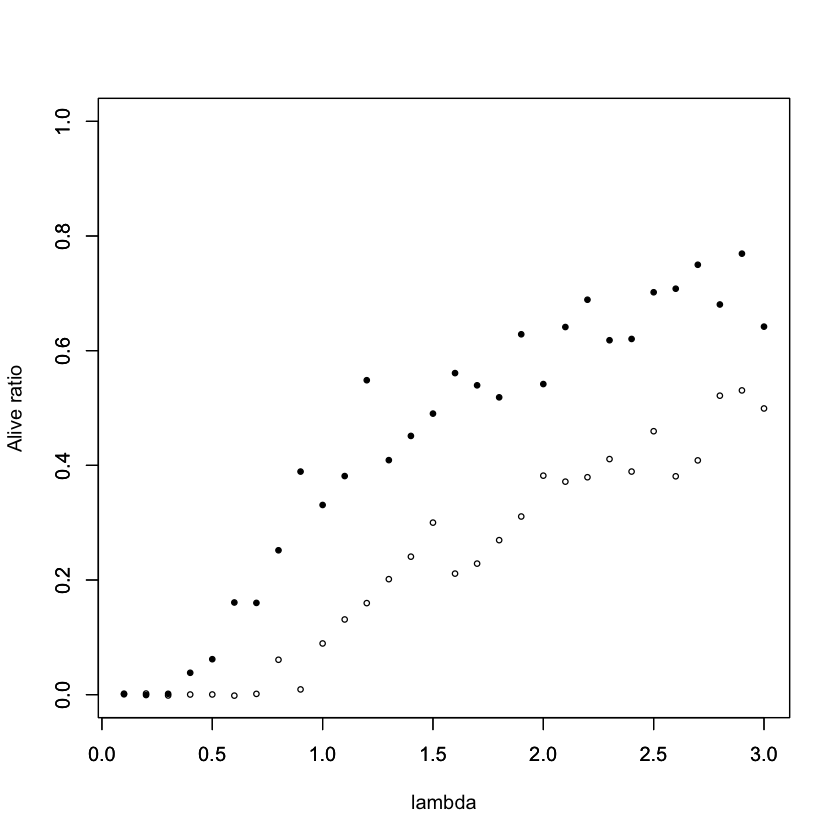

In [185]:
  plot(x = paramGrid[,1], y = jitter(mcGridAlive1, 1),ylim=c(0,1), pch = 19, cex = 0.6,xlab="",ylab="")
  par(new=T)
  plot(x = paramGrid2[,1], y = jitter(mcGridAlive2, 1),ylim=c(0,1), pch = 1, cex = 0.6, xlab='lambda',ylab='Alive ratio')

### Lambda/Kappa ratio
To compare the results based on ratio of lambda and kappa. We plotted both results against the ratio. We can see that since kappa is 2. The values for second output are more granular but stops at value 1.5. 

In [186]:
mcGrid2ratio = paramGrid[,1]/2

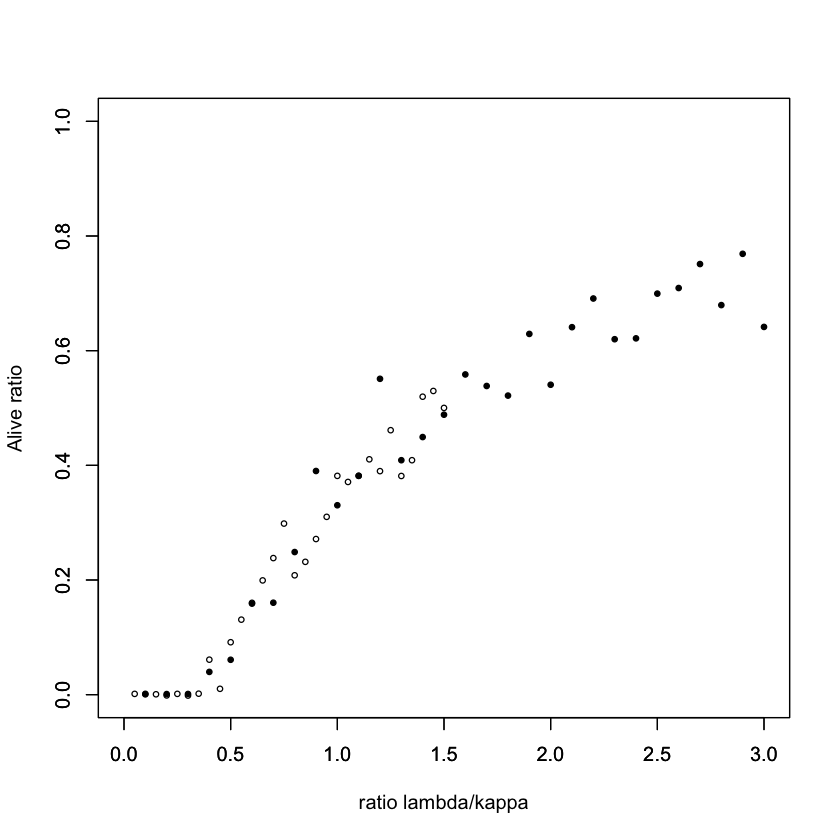

In [183]:
  plot(x = paramGrid[,1], y = jitter(mcGridAlive1, 1),xlim=c(0,3), ylim=c(0,1), pch = 19, cex = 0.6,xlab="",ylab="")
  par(new=T)
  plot(x = mcGrid2ratio, y = jitter(mcGridAlive2, 1),xlim=c(0,3), ylim=c(0,1), pch = 1, cex = 0.6, xlab='ratio lambda/kappa',ylab='Alive ratio')


### Conclusion
The plot above shows that the results are identical when the ratios are same in both simulation tests. Based on the study it is clear that the lifetime of a parallel computing system using branching process is more influenced by the ratio of creation rate and completion time than the individual creation rate or completion time. 